# Versão 1.1

Nessa versão utilizei K-means para os 6 clusteres, dados normalizados somente por feature e NÃO utilizei o filtro Kalman.

Coluna 'cycle_num' dos dados forma normalizados ( value / dataset.['cycle_num'].max() ) e depois multiplicando pelo valor novamente ao avaliar na métrica da competição. (melhora de 8%)

Outra modificação foi a inclusão desta coluna no treinamento do modelo. O resultado foi absurdamente melhorado. (imensurável a melhora no modelo)

In [1]:
#Importando as bibliotecas

# Data Analysis Tools
import pandas as pd
import numpy as np
from time import time
import logging as log

# Visualization Tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

# Machine Learning Tools
import sklearn
import sklearn.mixture as mix
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn import preprocessing
import xgboost as xgb
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
import pickle


#Scoreing tools
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
# from sklearn.metrics import mean_squared_log_error

# plt.rcParams['figure.figsize'] = (10, 10)

def get_sensor_names(tag_names):
    """ Get tagnames starting with sensor.
    
    :param tag_names: Input time series data frame
    
    :return list of string tag names starting with sensor.
    """
    
    return [tag_name for tag_name in tag_names if tag_name.startswith('sensor')]

c:\programdata\anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\programdata\anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#Tag Names que foram explicadas no arquivo Challenge Data description 2016
tag_names = ['unit','cycle_num', 'setting1','setting2',
         'setting3', 'sensor1', 'sensor2',
         'sensor3', 'sensor4', 'sensor5', 'sensor6',
         'sensor7', 'sensor8', 'sensor9', 'sensor10',
         'sensor11', 'sensor12', 'sensor13', 'sensor14',
         'sensor15', 'sensor16', 'sensor17', 'sensor18',
         'sensor19', 'sensor20', 'sensor21']

sensor_columns = get_sensor_names(tag_names)
train_data = pd.read_csv('train.txt', sep=' ', header=None, names=tag_names,index_col=False)
test_data = pd.read_csv('test.txt', sep=' ', header=None, names=tag_names,index_col=False)
final_test = pd.read_csv('final_test.txt', sep=' ', header=None, names=tag_names,index_col=False)

print "O dataset de treino tem {} linhas de dados e {} atributos.".format(*train_data.shape)
print "O dataset de teste tem {} linhas de dados e {} atributos.".format(*test_data.shape)
print "O dataset de testes finais tem {} linhas de dados e {} atributos.".format(*final_test.shape)


O dataset de treino tem 45918 linhas de dados e 26 atributos.
O dataset de teste tem 29820 linhas de dados e 26 atributos.
O dataset de testes finais tem 55156 linhas de dados e 26 atributos.


Analisando os três *'settings'* para observar alguma correlação.

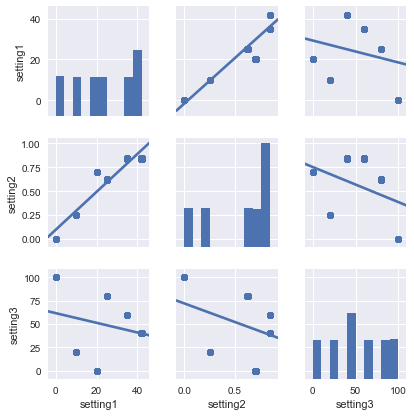

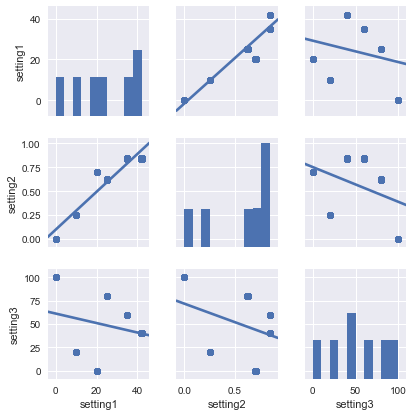

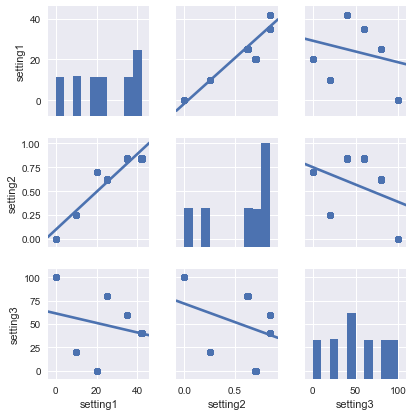

In [5]:
#Treino
settings_data_treino = train_data[['unit','setting1', 'setting2', 'setting3']]
target_treino = train_data[['cycle_num']]

sns.set(style="darkgrid", color_codes=True)
sns.pairplot(settings_data_treino.drop(['unit'], axis = 1),kind="reg", size=2)
plt.savefig('Correlation settings train data.png', format='png', dpi=100)

#Teste
settings_data_teste = test_data[['unit','setting1', 'setting2', 'setting3']]
target_teste = test_data[['cycle_num']]

sns.set(style="darkgrid", color_codes=True)
sns.pairplot(settings_data_teste.drop(['unit'], axis = 1),kind="reg", size=2)
plt.savefig('Correlation settings test data.png', format='png', dpi=100)

#Teste Final
settings_data_testefinal = final_test[['unit','setting1', 'setting2', 'setting3']]
target_testefinal = final_test[['cycle_num']]

sns.set(style="darkgrid", color_codes=True)
sns.pairplot(settings_data_testefinal.drop(['unit'], axis = 1),kind="reg", size=2)
plt.savefig('Correlation settings final test data.png', format='png', dpi=100)

Os *'setting1'* e *'setting2'* apresentam uma correlação, aparentemente linear.

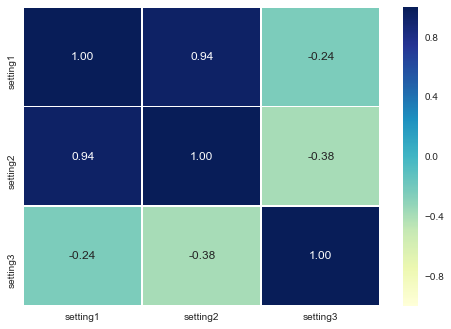

In [6]:
#Treino
fig = sns.heatmap(settings_data_treino.drop(['unit'], axis = 1).corr(),annot = True,fmt = ".2f",linewidths=.7,cmap="YlGnBu")
# plt.savefig('Correlation map train dataset.png', format='png', dpi=100)

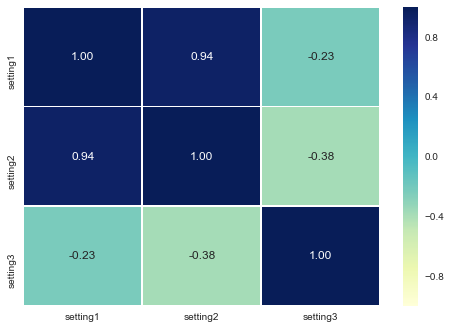

In [7]:
#Teste
fig = sns.heatmap(settings_data_teste.drop(['unit'], axis = 1).corr(),annot = True,fmt = ".2f",linewidths=.7,cmap="YlGnBu")
# plt.savefig('Correlation map test dataset.png', format='png', dpi=100)

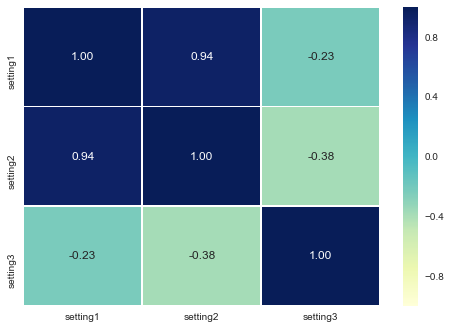

In [8]:
#Teste Final
fig = sns.heatmap(settings_data_testefinal.drop(['unit'], axis = 1).corr(),annot = True,fmt = ".2f",linewidths=.7,cmap="YlGnBu")
# plt.savefig('Correlation map final test dataset.png', format='png', dpi=100)

In [9]:
# # plot feature importance manually RANDOM FOREST
# Build a forest and compute the feature importances

# load data
X = settings_data_treino.drop(['unit'], axis = 1).values
y = target_treino.values

forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0,
                              max_depth = 1000)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

c:\programdata\anaconda2\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


Feature ranking:
1. feature 0 (0.756049)
2. feature 1 (0.243594)
3. feature 2 (0.000357)


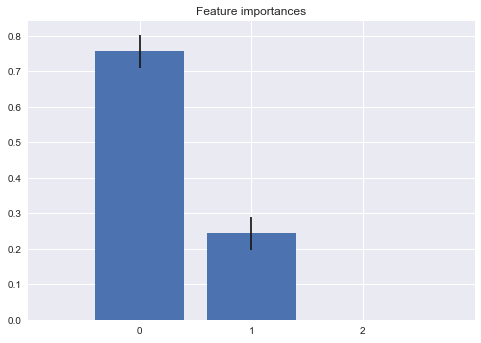

In [10]:
# plot# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()


plt.savefig('Features importances.png', format='png', dpi=100)

Nas linhas abaixos, irei reduzir o número de parâmetros de operação ou *setting* para apenas dois através da média entre os *setting 1* e do *setting 2*

In [11]:
#Treino
new_setting_treino = pd.DataFrame({'mean_setting1_and_setting2':(settings_data_treino['setting1'] + settings_data_treino['setting2'])/2})
s_treino = settings_data_treino['setting3']
r_treino = settings_data_treino['unit']
settings_final_treino = pd.concat([new_setting_treino,s_treino], axis = 1)
print settings_final_treino.tail()
print ('\n')

#Teste
new_setting_teste = pd.DataFrame({'mean_setting1_and_setting2':(settings_data_teste['setting1'] + settings_data_teste['setting2'])/2})
s_teste = settings_data_teste['setting3']
r_teste = settings_data_teste['unit']
settings_final_teste = pd.concat([new_setting_teste,s_teste], axis = 1)
print settings_final_teste.tail()
print ('\n')

#Teste Final
new_setting_testefinal = pd.DataFrame({'mean_setting1_and_setting2':(settings_data_testefinal['setting1'] + settings_data_testefinal['setting2'])/2})
s_testefinal = settings_data_testefinal['setting3']
r_testefinal = settings_data_testefinal['unit']
settings_final_testefinal = pd.concat([new_setting_testefinal,s_testefinal], axis = 1)
print settings_final_testefinal.tail()


       mean_setting1_and_setting2  setting3
45913                    21.42330      40.0
45914                    21.42220      40.0
45915                    21.41995      40.0
45916                    17.92130      60.0
45917                    12.81435      80.0


       mean_setting1_and_setting2  setting3
29815                    17.92085      60.0
29816                    12.81205      80.0
29817                    10.35215       0.0
29818                    10.35185       0.0
29819                    10.34980       0.0


       mean_setting1_and_setting2  setting3
55151                    17.91965      60.0
55152                     0.00065     100.0
55153                    17.92430      60.0
55154                     5.12930      20.0
55155                    17.92395      60.0


('O resultado silh_score e = 0.623192037212', 'para um cluster_size de 2')
('O resultado silh_score e = 0.769197587522', 'para um cluster_size de 3')
('O resultado silh_score e = 0.856588662449', 'para um cluster_size de 4')
('O resultado silh_score e = 0.930887231078', 'para um cluster_size de 5')
('O resultado silh_score e = 0.999521629341', 'para um cluster_size de 6')
('O resultado silh_score e = 0.903944155812', 'para um cluster_size de 7')
('O resultado silh_score e = 0.852982473187', 'para um cluster_size de 8')
('O resultado silh_score e = 0.792692250478', 'para um cluster_size de 9')


O número ótimo de cluster é = 6




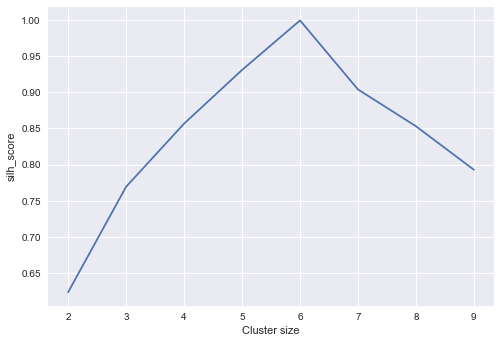

In [12]:
#Treino
scores= []
cluster_sizes = range(2,10)

#Set a seed value for the random number enerator to get repeatable results
np.random.seed(10)

for num_clusters in cluster_sizes:
    clusterer = KMeans(n_clusters=num_clusters, 
                    n_init=100, 
                    max_iter=5000,
                    random_state=10)
    
    cluster_labels = clusterer.fit_predict(new_setting_treino)
    
    size = num_clusters
    
    centers = clusterer.cluster_centers_
    
    silh_score = silhouette_score(new_setting_treino.values, cluster_labels, sample_size=2000)
    scores.append(silh_score)
    print ('O resultado silh_score e = {}'.format(silh_score),'para um cluster_size de {}'.format(size))
    
print ('\n')    
print 'O número ótimo de cluster é = {}'.format(cluster_sizes[np.argmax(scores)])
chosen_cluster_size = cluster_sizes[np.argmax(scores)]
print ('\n')  
plt.plot(cluster_sizes, scores)
plt.ylabel('silh_score')
plt.xlabel('Cluster size')
plt.savefig('Cluster size para os dados de treino.png', format='png', dpi=100)


predictions = KMeans(n_clusters=chosen_cluster_size).fit_predict(new_setting_treino)


values = predictions
index = ['y']
columns = ['overall setting']

overall_setting_train = pd.DataFrame(data=values, columns=columns, dtype='int')

('O resultado silh_score e = 0.626856509969', 'para um cluster_size de 2')
('O resultado silh_score e = 0.775053295345', 'para um cluster_size de 3')
('O resultado silh_score e = 0.851341101317', 'para um cluster_size de 4')
('O resultado silh_score e = 0.924104457147', 'para um cluster_size de 5')
('O resultado silh_score e = 0.999532410118', 'para um cluster_size de 6')
('O resultado silh_score e = 0.901923017791', 'para um cluster_size de 7')
('O resultado silh_score e = 0.852985679161', 'para um cluster_size de 8')
('O resultado silh_score e = 0.784005818117', 'para um cluster_size de 9')


O número ótimo de cluster é = 6




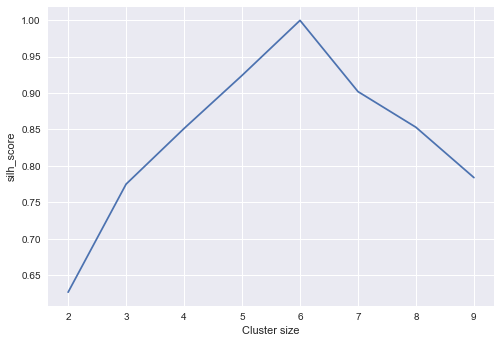

In [13]:
#Testes
scores= []
cluster_sizes = range(2,10)

#Set a seed value for the random number enerator to get repeatable results
np.random.seed(10)

for num_clusters in cluster_sizes:
    clusterer = KMeans(n_clusters=num_clusters, 
                    n_init=100, 
                    max_iter=5000,
                    random_state=10)
    
    cluster_labels = clusterer.fit_predict(new_setting_teste)
    
    size = num_clusters
    
    centers = clusterer.cluster_centers_
    
    silh_score = silhouette_score(new_setting_teste.values, cluster_labels, sample_size=2000)
    scores.append(silh_score)
    print ('O resultado silh_score e = {}'.format(silh_score),'para um cluster_size de {}'.format(size))
    
print ('\n')    
print 'O número ótimo de cluster é = {}'.format(cluster_sizes[np.argmax(scores)])
chosen_cluster_size = cluster_sizes[np.argmax(scores)]
print ('\n')  
plt.plot(cluster_sizes, scores)
plt.ylabel('silh_score')
plt.xlabel('Cluster size')
plt.savefig('Cluster size para os dados de teste.png', format='png', dpi=100)


predictions = KMeans(n_clusters=chosen_cluster_size).fit_predict(new_setting_teste)


values = predictions
index = ['y']
columns = ['overall setting']

overall_setting_test = pd.DataFrame(data=values, columns=columns, dtype='int')

('O resultado silh_score e = 0.629626039475', 'para um cluster_size de 2')
('O resultado silh_score e = 0.772169769914', 'para um cluster_size de 3')
('O resultado silh_score e = 0.854695776292', 'para um cluster_size de 4')
('O resultado silh_score e = 0.929526954056', 'para um cluster_size de 5')
('O resultado silh_score e = 0.999523749076', 'para um cluster_size de 6')
('O resultado silh_score e = 0.902013794488', 'para um cluster_size de 7')
('O resultado silh_score e = 0.841392906665', 'para um cluster_size de 8')
('O resultado silh_score e = 0.792073935219', 'para um cluster_size de 9')


O número ótimo de cluster é = 6




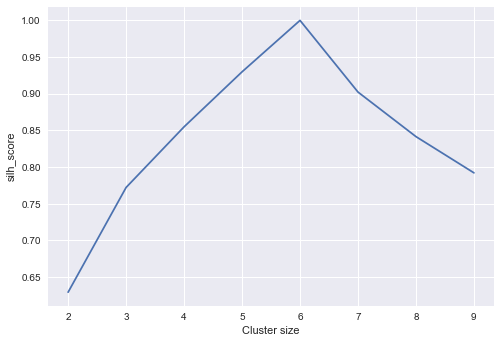

In [14]:
#Testes Finais
scores= []
cluster_sizes = range(2,10)

#Set a seed value for the random number enerator to get repeatable results
np.random.seed(10)

for num_clusters in cluster_sizes:
    clusterer = KMeans(n_clusters=num_clusters, 
                    n_init=100, 
                    max_iter=5000,
                    random_state=10)
    
    cluster_labels = clusterer.fit_predict(new_setting_testefinal)
    
    size = num_clusters
    
    centers = clusterer.cluster_centers_
    
    silh_score = silhouette_score(new_setting_testefinal.values, cluster_labels, sample_size=2000)
    scores.append(silh_score)
    print ('O resultado silh_score e = {}'.format(silh_score),'para um cluster_size de {}'.format(size))
    
print ('\n')    
print 'O número ótimo de cluster é = {}'.format(cluster_sizes[np.argmax(scores)])
chosen_cluster_size = cluster_sizes[np.argmax(scores)]
print ('\n')  
plt.plot(cluster_sizes, scores)
plt.ylabel('silh_score')
plt.xlabel('Cluster size')
plt.savefig('Cluster size para os dados de teste final.png', format='png', dpi=100)


predictions = KMeans(n_clusters=chosen_cluster_size).fit_predict(new_setting_testefinal)


values = predictions
index = ['y']
columns = ['overall setting']

overall_setting_finaltest = pd.DataFrame(data=values, columns=columns, dtype='int')

In [ ]:
#Plot dos clusteres realizados

from mpl_toolkits.mplot3d import Axes3D

C = centers

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(settings_data_treino['setting1'],settings_data_treino['setting2'],settings_data_treino['setting3'])
ax.scatter(C, marker='*', c='r')
plt.xlabel('setting1', fontsize=10 )
plt.ylabel('setting2', fontsize=10)
plt.zlabel('setting3', fontsize=10)
plt.tick_params(labelsize=15)
plt.savefig('Settings distribution along space.png', format='png', dpi=100)


In [15]:
#Treino
sensor_names = get_sensor_names(tag_names)
sensor_data_train = train_data[sensor_names]

#Teste
sensor_names = get_sensor_names(tag_names)
sensor_data_test = test_data[sensor_names]

#Teste Final
sensor_names = get_sensor_names(tag_names)
sensor_data_finaltest = final_test[sensor_names]

In [17]:
#Treino
target_train = train_data[['cycle_num']]
frames_treino = [r_treino,overall_setting_train,sensor_data_train,target_train]
data_set_treino = pd.concat(frames_treino, axis = 1)


#Teste
target_teste = train_data[['cycle_num']]
frames_teste = [r_teste,overall_setting_test,sensor_data_test,target_teste]
data_set_teste = pd.concat(frames_teste, axis = 1)


#Teste Final
target_testefinal = final_test[['cycle_num']]
frames_testefinal = [r_testefinal,overall_setting_finaltest,sensor_data_finaltest,target_testefinal]
data_set_testefinal = pd.concat(frames_testefinal, axis = 1)



# Normalize Function

In [30]:
#Normalizing the data by operations settings

min_max_scaler = preprocessing.MinMaxScaler()

# settings_range = range(0,6)
# np.random.seed(2015)



def normalize (normal):
        
    clustered_data_normalized = pd.DataFrame()

    tag_names_2 = ['unit','cycle_num', 'overall_setting', 'sensor1', 'sensor2',
         'sensor3', 'sensor4', 'sensor5', 'sensor6',
         'sensor7', 'sensor8', 'sensor9', 'sensor10',
         'sensor11', 'sensor12', 'sensor13', 'sensor14',
         'sensor15', 'sensor16', 'sensor17', 'sensor18',
         'sensor19', 'sensor20', 'sensor21']
    
    
    colNames = ('sensor1', 'sensor2',
         'sensor3', 'sensor4', 'sensor5', 'sensor6',
         'sensor7', 'sensor8', 'sensor9', 'sensor10',
         'sensor11', 'sensor12', 'sensor13', 'sensor14',
         'sensor15', 'sensor16', 'sensor17', 'sensor18',
         'sensor19', 'sensor20', 'sensor21')

    for settings in range(0,6):
        
#         print ('Normalizando setting{}'.format(settings))
                     
        clustered_data_to_normalize = normal.loc[normal['overall setting'] == settings]
        
#         print clustered_data_to_normalize.describe()

        df_resto = pd.DataFrame(clustered_data_to_normalize[['unit','cycle_num','overall setting']])
        
        #print df_resto.describe()
        
        min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1),copy=True)
        
        pre_scaled = min_max_scaler.fit_transform(clustered_data_to_normalize.drop(['overall setting', 'unit','cycle_num'], axis = 1))

        scaled = pd.DataFrame(pre_scaled, columns = colNames,index = df_resto.index)
        
        scaled_2 = pd.concat([df_resto,scaled],axis=1)

#         print clustered_data_normalized.isnull().sum()
        
        clustered_data_normalized = clustered_data_normalized.append(scaled_2)
        
#         print ('Done normalization!')
        
        #print scaled.shape
        #print df_resto.shape
                     
                                                          
    return (clustered_data_normalized)

#Treino
data_set_normalized_train = normalize(data_set_treino)
# data_set_normalized_train.describe()

#Teste
data_set_normalized_test = normalize(data_set_teste)
# data_set_normalized_test.describe()

#Teste Final
data_set_normalized_finaltest = normalize(data_set_testefinal)
# data_set_normalized_finaltest.describe()

Ao normalizar os dados vemos que alguns sensores não tem dispersão. Então podemos tirá-los dos dados.

In [32]:
#Treino
train_final_data = data_set_normalized_train.drop(['sensor1', 'sensor5','sensor18','sensor19','sensor21'], axis = 1)

#Teste
test_final_data = data_set_normalized_test.drop(['sensor1', 'sensor5','sensor18','sensor19','sensor21'], axis = 1)

#Teste Final
finaltest_final_data = data_set_normalized_finaltest.drop(['sensor1', 'sensor5','sensor18','sensor19','sensor21'], axis = 1)

In [33]:
#Treino
train_final_data = train_final_data.sort_index(axis=0,ascending = True)

#Teste
test_final_data = test_final_data.sort_index(axis=0,ascending = True)

#Teste Final
finaltest_final_data = finaltest_final_data.sort_index(axis=0,ascending = True)

In [34]:
train_final_data.head()

,unit,cycle_num,overall setting,sensor2,sensor3,sensor4,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor20
0,1,1,3,0.207317,0.385666,0.390048,0.0,0.683047,0.232143,0.130524,0.0,0.342105,0.744928,0.396552,0.143733,0.289960,0.0,0.300000,0.608247
1,1,2,2,0.260450,0.301230,0.326552,1.0,0.639085,0.204545,0.121456,0.0,0.241379,0.635762,0.533333,0.165187,0.263285,0.0,0.300000,0.706897
2,1,3,4,0.316993,0.477684,0.233520,0.0,0.631579,0.153094,0.104530,0.0,0.363014,0.605072,0.149390,0.151602,0.553330,0.0,0.444444,0.477778
3,1,4,0,0.300000,0.511334,0.339116,0.0,0.586124,0.030303,0.130407,1.0,0.281690,0.540625,0.093750,0.118484,0.361931,0.0,0.300000,0.516129
4,1,5,1,0.383901,0.437049,0.376994,0.0,0.419718,0.196825,0.097396,0.0,0.180000,0.444444,0.205357,0.180714,0.161937,0.0,0.300000,1.000000


# Correlation between the sensors

In [22]:
def plot_corr_heatmap(corr_matrix):
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap="Greens", vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": 0.9},annot= False)
    plt.savefig('Correlation between the sensors.png', format='png', dpi=100)

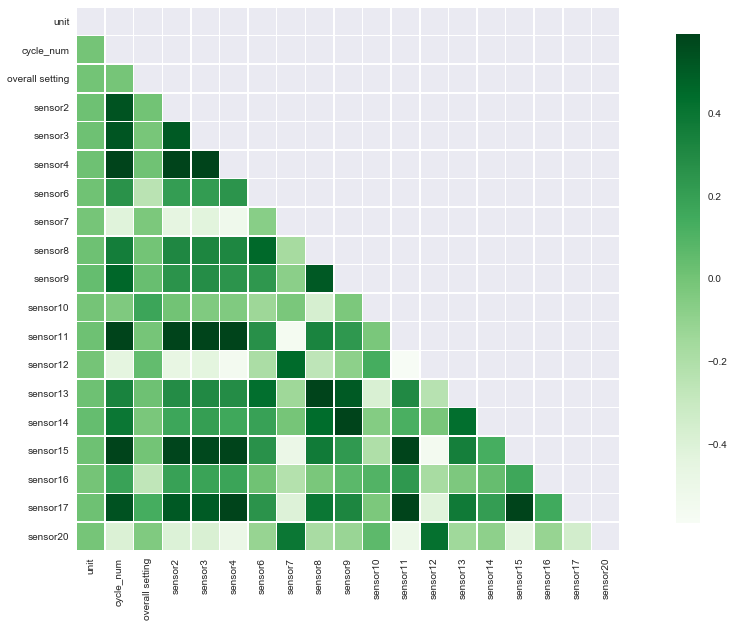

In [23]:
#Treino
corr = train_final_data.corr()
plot_corr_heatmap(corr)

# Plots dos sensores

Nas linhas abaixo mostrarei como os dados dos sensores se comportam com o passar dos ciclos (tempo)

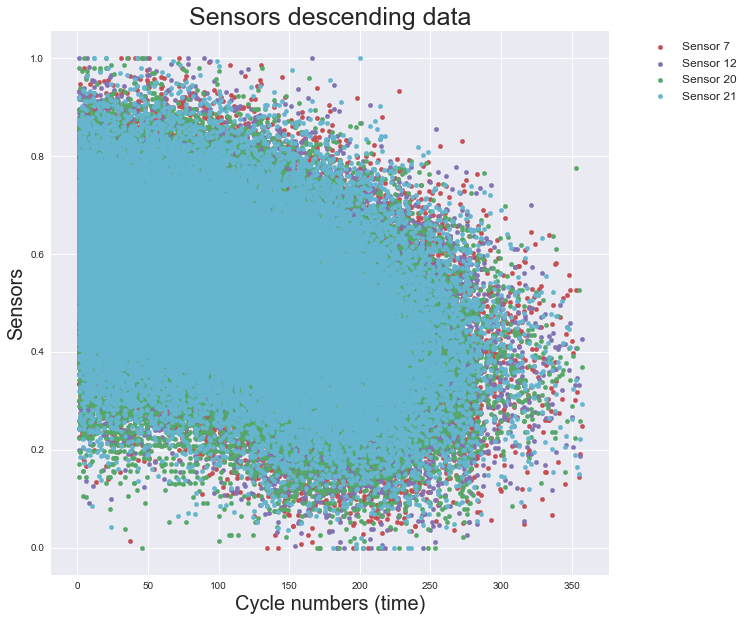

In [24]:
ax = data_set_normalized_train.plot(kind="scatter", x="cycle_num",y="sensor7", color="r", label="Sensor 7",figsize=(10,10))
data_set_normalized_train.plot(x="cycle_num",y="sensor12", color="m", label="Sensor 12", ax=ax,kind="scatter")
data_set_normalized_train.plot(x="cycle_num",y="sensor20", color="g", label="Sensor 20", ax=ax,kind="scatter")
data_set_normalized_train.plot(x="cycle_num",y="sensor21", color="c", label="Sensor 21", ax=ax,kind="scatter")
# data_set_normalized_train.plot(x="cycle_num",y="sensor11", color="b", label="Sensor 11", ax=ax,kind="scatter")
# data_set_normalized_train.plot(x="cycle_num",y="sensor15", color="c", label="Sensor 15", ax=ax,kind="scatter")


ax.set_xlabel("Cycle numbers (time)",fontsize=20)
ax.set_ylabel("Sensors",fontsize=20)
plt.title('Sensors descending data', fontsize=25)
plt.legend(fontsize=12,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.savefig('Sensors descending data.png', format='png', dpi=100)
plt.show()

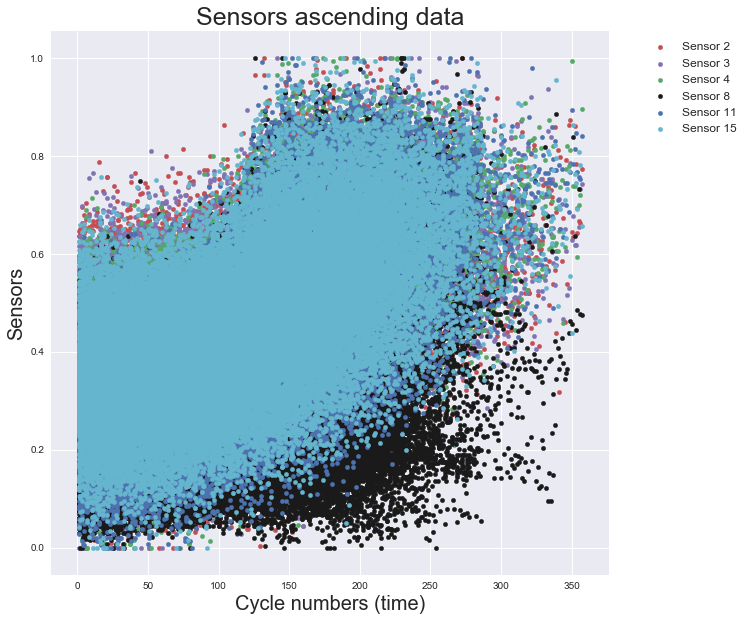

In [25]:
ax = data_set_normalized_train.plot(kind="scatter", x="cycle_num",y="sensor2", color="r", label="Sensor 2",figsize=(10,10))
data_set_normalized_train.plot(x="cycle_num",y="sensor3", color="m", label="Sensor 3", ax=ax,kind="scatter")
data_set_normalized_train.plot(x="cycle_num",y="sensor4", color="g", label="Sensor 4", ax=ax,kind="scatter")
data_set_normalized_train.plot(x="cycle_num",y="sensor8", color="k", label="Sensor 8", ax=ax,kind="scatter")
data_set_normalized_train.plot(x="cycle_num",y="sensor11", color="b", label="Sensor 11", ax=ax,kind="scatter")
data_set_normalized_train.plot(x="cycle_num",y="sensor15", color="c", label="Sensor 15", ax=ax,kind="scatter")
# data_set_normalized_train.plot(x="cycle_num",y="sensor14", color="C1", label="Sensor 14", ax=ax,kind="scatter")
# data_set_normalized_train.plot(x="cycle_num",y="sensor9", color="C3", label="Sensor 9", ax=ax,kind="scatter")

ax.set_xlabel("Cycle numbers (time)",fontsize=20)
ax.set_ylabel("Sensors",fontsize=20)
plt.title('Sensors ascending data', fontsize=25)
plt.legend(fontsize=12,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.savefig('Sensors ascending data.png', format='png', dpi=100)
plt.show()

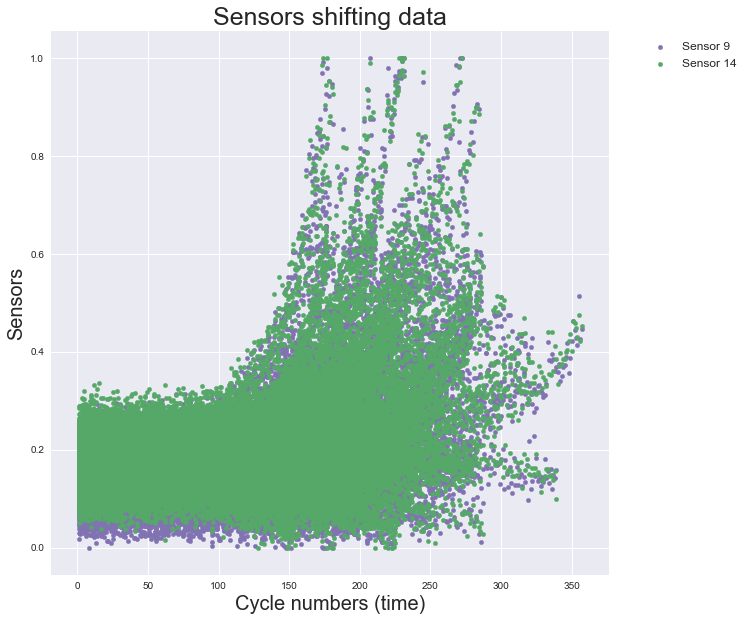

In [26]:
ax = data_set_normalized_train.plot(kind="scatter", x="cycle_num",y="sensor9", color="C9", label="Sensor 9",figsize=(10,10))
data_set_normalized_train.plot(x="cycle_num",y="sensor14", color="C1", label="Sensor 14", ax=ax,kind="scatter")
# data_set_normalized_train.plot(x="cycle_num",y="sensor4", color="g", label="Sensor 4", ax=ax,kind="scatter")
# data_set_normalized_train.plot(x="cycle_num",y="sensor8", color="k", label="Sensor 8", ax=ax,kind="scatter")
# data_set_normalized_train.plot(x="cycle_num",y="sensor11", color="b", label="Sensor 11", ax=ax,kind="scatter")
# data_set_normalized_train.plot(x="cycle_num",y="sensor15", color="c", label="Sensor 15", ax=ax,kind="scatter")


ax.set_xlabel("Cycle numbers (time)",fontsize=20)
ax.set_ylabel("Sensors",fontsize=20)
plt.title('Sensors shifting data', fontsize=25)
plt.legend(fontsize=12,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.savefig('Sensors shifting data.png', format='png', dpi=100)
plt.show()

# Interpretação dos gráficos dos sensores

# Definição do set de teste e do set target

In [27]:
##Treino
#Coluna targe do dataset
target_final_data_train = train_final_data['cycle_num']
target_final_data_train_scaled = pd.DataFrame(data = target_final_data_train / target_final_data_train.max() , columns=['cycle_num'])
#Colunas com os dados
train_final_data['sensor9,14_break'] = np.where(train_final_data['cycle_num'] > 130,1,0)
train_final_data = train_final_data.drop(['cycle_num'], axis = 1)

##Teste
#Coluna targe do dataset
target_final_data_test = test_final_data['cycle_num']
target_final_data_test_scaled = pd.DataFrame(data = target_final_data_test / target_final_data_test.max(), columns=['cycle_num'])
#Colunas com os dados
test_final_data['sensor9,14_break'] = np.where(test_final_data['cycle_num'] > 130,1,0)
test_final_data = test_final_data.drop(['cycle_num'], axis = 1)

##Teste Final
#Coluna targe do dataset
target_final_data_finaltest = finaltest_final_data['cycle_num']
target_final_data_finaltest_scaled = pd.DataFrame(data = target_final_data_finaltest / target_final_data_finaltest.max(), columns=['cycle_num'])
#Colunas com os dados
finaltest_final_data['sensor9,14_break'] = np.where(finaltest_final_data['cycle_num'] > 130,1,0)
finaltest_final_data = finaltest_final_data.drop(['cycle_num'], axis = 1)

# Salvando os datasets para aplicar modelos

In [29]:
#Dataset de Treino
train_final_data.to_csv('train_final_data.csv',sep=',',index = False)
target_final_data_train_scaled.to_csv('target_final_data_train_scaled.csv',sep=',',index = False, header = False)
target_final_data_train.to_csv('target_final_data_train.csv',sep=',',index = False, header = False)

#Dataset de Teste
test_final_data.to_csv('test_final_data.csv',sep=',',index = False)
target_final_data_test_scaled.to_csv('target_final_data_test_scaled.csv',sep=',',index = False, header = False)
target_final_data_test.to_csv('target_final_data_test.csv',sep=',',index = False, header = False)

#Dataset de Teste Final
finaltest_final_data.to_csv('finaltest_final_data.csv',sep=',',index = False)
target_final_data_finaltest_scaled.to_csv('target_final_data_finaltest_scaled.csv',sep=',',index = False, header = False)
target_final_data_finaltest.to_csv('target_final_data_finaltest.csv',sep=',',index = False, header = False)